In [1]:
from access_data import *
from preparing_data import *
from evaluating_data import *
from feature_engineering import *

C:\Users\Max\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
#getting all data
df_huff= only_relevant_columns(dropping_new_category(combine_huff_categories(get_huffpost())))

# df_huff = df_huff[df_huff.category != 'RANDOM']
# df_huff = df_huff[df_huff.category != 'LIFESTYLE'] 

df_20news = get_20news()

df_all = df_huff
df_all = df_all.append(df_20news)

df_relevant = add_word_vector_column(df_all)
df_relevant = delete_short_datasets(df_all)

# getting single label
df_science = get_test_data_for_label(df_all.copy(), 'SCIENCE', 0.3)
df_sport = get_test_data_for_label(df_all.copy(), 'SPORTS', 0.3)
df_politics = get_test_data_for_label(df_all.copy(), 'POLITICS', 0.3)
df_lifestyle = get_test_data_for_label(df_all.copy(), 'LIFESTYLE', 0.3)
df_health = get_test_data_for_label(df_all.copy(), 'HEALTH', 0.3)
df_education = get_test_data_for_label(df_all.copy(), 'EDUCATION', 0.3)
df_worldpost = get_test_data_for_label(df_all.copy(), 'WORLDPOST', 0.3)
df_impact = get_test_data_for_label(df_all.copy(), 'IMPACT', 0.3)
df_business = get_test_data_for_label(df_all.copy(), 'BUSINESS', 0.3)
df_random = get_test_data_for_label(df_all.copy(), 'RANDOM', 0.3)

datasets = {"SCIENCE": df_science, "SPORTS": df_sport, "POLITICS": df_politics, "LIFESTYLE": df_lifestyle, "HEALTH": df_health, "EDUCATION": df_education, "WORLDPOST": df_worldpost, "IMPACT": df_impact, "BUSINESS": df_business, "RANDOM": df_random}

# from sklearn.decomposition import TruncatedSVD
# svd = TruncatedSVD(n_components=2500, n_iter=4, random_state=42)    # there are 52120 features

C:\Users\Max\Project\Data\News_Category_Dataset_new.json


C:\Users\Max\Project\access_data.py:233: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  random_df['category'] = 'NONE'


There were not enough data to create a split with split_ratio 0.3. Only selected 99332 instead of 114380 random data
There were not enough data to create a split with split_ratio 0.3. Only selected 92772 instead of 136247 random data


# new functions

In [3]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import column_or_1d

class MyLabelEncoder(LabelEncoder):

    def fit(self, y):
        y = column_or_1d(y, warn=True)
        self.classes_ = pd.Series(y).unique()
        return self

In [4]:
from sklearn.utils.fixes import signature
from sklearn.metrics import precision_recall_curve

def print_prec_rec(y_test, pred):
    precision, recall, _ = precision_recall_curve(y_test, pred)

    # In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
    step_kwargs = ({'step': 'post'}
                   if 'step' in signature(plt.fill_between).parameters
                   else {})
    pyplot.step(recall, precision, color='b', alpha=0.2,
             where='post')
    pyplot.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)
    
    print(type(recall))
    print(recall)
    print(type(precision))
    print(precision)

    pyplot.xlabel('Recall')
    pyplot.ylabel('Precision')
    pyplot.ylim([0.0, 1.05])
    pyplot.xlim([0.0, 1.0])
    pyplot.show()

In [5]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot

def print_AUC(X_test, prob, key):
    # calculate AUC
    auc = roc_auc_score(X_test, prob)
    print('AUC: %.3f' % auc)
    # calculate roc curve
    fpr, tpr, thresholds = roc_curve(X_test, prob)
    # plot no skill
    pyplot.plot([0, 1], [0, 1], linestyle='--')
    # plot the roc curve for the model
    pyplot.plot(fpr, tpr, marker='.')
    # show the plot
    pyplot.title(key)
    pyplot.show()

In [22]:
from sklearn.metrics import f1_score

def print_f1(y_true, y_pred):
    print("F1 Score (macro, micro, weighted): ")
    print(f1_score(y_true, y_pred, average='macro'))
    f1 = f1_score(y_true, y_pred, average='micro')
    print(f1)  
    print(f1_score(y_true, y_pred, average='weighted'))  
    return f1

# determine parameters (SVC)

In [28]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

from sklearn.preprocessing import LabelEncoder
from sklearn.svm import LinearSVC

pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words='english', min_df=5)),
    ('svc', LinearSVC()),
])

# work with 10%
parameters_pipeline = {
    'tfidf__max_df': (0.15, 0.25),
    'svc__C': [0.1, 0.25, 0.5, 1, 5, 10],
}

grid_search = GridSearchCV(pipeline, parameters_pipeline, n_jobs=-1, cv=3)

for key, df in datasets.items():
    print("Dataset: "+key)
    
    #splitting data
    split_map_all = split_dataset(df)
    X_train_all = split_map_all['X_train']
    y_train_all = split_map_all['y_train']
    X_test_all = split_map_all['X_test']
    y_test_all = split_map_all['y_test']
    
    #encoding label
    integer_encoded_train = y_train_all.replace("NONE", 0).replace(key, 1)
    integer_encoded_test = y_test_all.replace("NONE", 0).replace(key, 1)
#    label_encoder = MyLabelEncoder()
#    label_encoder.fit(["NONE", key])
#    integer_encoded_train = label_encoder.transform(y_train_all)
#    integer_encoded_test = label_encoder.transform(y_test_all)
#    print("0: "+ label_encoder.inverse_transform(0))
#    print("1: "+ label_encoder.inverse_transform(1))    
#    print(y_train_all.unique())
#    print(integer_encoded_test[:20])

    grid_search.fit(X_train_all, integer_encoded_train)

    print(grid_search.best_params_)
    print(grid_search.best_score_)
    pipeline_best = grid_search.best_estimator_
    accuracy = pipeline_best.score(X_test_all, integer_encoded_test)
    print('The accuracy on testing set is: {0:.1f}%'.format(accuracy*100))

Dataset: SCIENCE
TRAIN: [ 9975   478 11889 ... 19803 27559 27463] TEST: [19232  8195 25501 ... 14809 26032 23200]
TRAIN: [11105 25912 11690 ... 18426 20577 19001] TEST: [ 4072 14504 23642 ...  9782  3363  4826]
TRAIN: [25957  7494 14539 ... 13265 21465  1473] TEST: [28103 17290 23674 ...   528 10190 15578]
TRAIN: [ 4638  4038  9709 ... 27775  9766  6430] TEST: [18428  8819 13639 ... 23460  5780  6300]
TRAIN: [ 9533  3232  9240 ... 27884  7049 25753] TEST: [22600 14826 25084 ...  7760 10021 21877]
0: NONE
1: SCIENCE


C:\Users\Max\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Max\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


{'svc__C': 0.5, 'tfidf__max_df': 0.15}
0.9036242389098289
The accuracy on testing set is: 90.8%
Dataset: SPORT
TRAIN: [24984 10558 10995 ...   609  8483 12210] TEST: [23212 22191 20015 ... 19767 24476 14857]
TRAIN: [18493  1877  7421 ... 19491  8961 17558] TEST: [11742   300  6014 ... 18153  8133 19345]
TRAIN: [17165  4837 26025 ... 21576 18177 15205] TEST: [11332  5458  5814 ... 25421 12743  5583]
TRAIN: [15643 13195 13056 ... 12681 17391 18158] TEST: [24815  2544 13635 ...  7318 15689 16061]
TRAIN: [14020  6802   327 ...  9449 20954  9232] TEST: [12509 12223 18107 ...  3411 22723 16605]
0: NONE
1: SPORTS


C:\Users\Max\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Max\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


{'svc__C': 0.5, 'tfidf__max_df': 0.15}
0.9285895003162555
The accuracy on testing set is: 93.2%
Dataset: POLITICS
TRAIN: [101684 103576 122187 ...  15374   7845 131736] TEST: [ 50312 131837  81378 ...  59289  41766 125319]
TRAIN: [ 38886  19447 128828 ...  52868 131490  33832] TEST: [ 65197  25274  29430 ... 108403  61728  15489]
TRAIN: [ 79968  48573  72398 ...  95446 125260 120559] TEST: [ 99474 107105  18029 ...  84102  87575  61776]
TRAIN: [ 85378  62120  86993 ... 103919  49241 124957] TEST: [ 23709 126057  93346 ... 116051  12253 117520]
TRAIN: [ 28357  74722  39288 ...   9031 115431   3798] TEST: [ 79614  70070  50413 ...   8440 109355  26987]
0: NONE
1: POLITICS


C:\Users\Max\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Max\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


{'svc__C': 0.25, 'tfidf__max_df': 0.15}
0.8840585132253358
The accuracy on testing set is: 89.0%
Dataset: LIFESTYLE
TRAIN: [ 11766 120575  53223 ...   9141 133011 108463] TEST: [  3043  49881  40769 ...  86787 122507 124754]
TRAIN: [ 98516 115212  36958 ...  98860  43558  91753] TEST: [ 78686  63711  60282 ...  13869  95691 129873]
TRAIN: [ 81429  73379 122998 ... 119414 132273 107802] TEST: [ 31392 118638  84167 ...  77002  15306 111746]
TRAIN: [ 16596 122047  60481 ...  13159  62726  42332] TEST: [ 81613  65986  43134 ... 113402  77783  17324]
TRAIN: [  8865 120375  31225 ... 131784 121872  32651] TEST: [ 81198 118972  62644 ... 112998  89424  33855]
0: LIFESTYLE
1: NONE


C:\Users\Max\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Max\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


{'svc__C': 0.25, 'tfidf__max_df': 0.15}
0.868382655542669
The accuracy on testing set is: 87.3%
Dataset: HEALTH
TRAIN: [24380 30349 30868 ... 20840 16216 27998] TEST: [ 4385  6438  2251 ... 10102  8276 17359]
TRAIN: [14739 34432 23259 ... 16257 22504 13086] TEST: [26691  6363 23256 ... 12558 24166 28517]
TRAIN: [37418 17836 16918 ...  1754  1883 24624] TEST: [36218  1657 18216 ...  9267 17278 32609]
TRAIN: [22134 33916 38161 ... 34035 12682 36178] TEST: [24011  7193 32678 ... 27254 13967  8582]
TRAIN: [33839 16006  6256 ... 32835 16015  9947] TEST: [ 6419 36085 40016 ... 32947  3917  2583]
0: HEALTH
1: NONE


C:\Users\Max\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Max\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


{'svc__C': 0.25, 'tfidf__max_df': 0.15}
0.857402361489555
The accuracy on testing set is: 86.4%
Dataset: EDUCATION
TRAIN: [1360 4858 1938 ... 6446 3763 4206] TEST: [7263 1133 7921 ... 2501 6644 5689]
TRAIN: [1176 5669 3607 ... 8097 2304 1253] TEST: [8150 3356 4949 ... 6984 4590 3247]
TRAIN: [3148 4014 6436 ... 4461 6410 6868] TEST: [3981 7730  786 ... 1564 2850 5575]
TRAIN: [6676 5604 3910 ... 3499 9155 7561] TEST: [ 286  887 3276 ... 1123 6301 6295]
TRAIN: [2422 2175  762 ...  613 6728 4123] TEST: [8690 8939 5100 ... 7877 1550 3293]
0: EDUCATION
1: NONE


C:\Users\Max\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Max\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


{'svc__C': 0.25, 'tfidf__max_df': 0.15}
0.8929083094555874
The accuracy on testing set is: 90.3%
Dataset: WORLDPOST
TRAIN: [30851 22579  4469 ... 18791 20562 11705] TEST: [13795 25968 32238 ... 19664 16511  6893]
TRAIN: [31521 26610 35972 ... 11659  4364 34572] TEST: [30515   450 13471 ... 15369 11206  5765]
TRAIN: [ 2953 18928  8881 ... 26617 11679 30877] TEST: [20973 25372 34697 ... 15163  2796 19308]
TRAIN: [26222 10734 13957 ... 34401 18348  7771] TEST: [32703 34412 16568 ... 22399 16909  5806]
TRAIN: [32499  1589  1854 ... 15429  6380 35341] TEST: [34632  6533 15073 ... 36352  6323 19383]
0: NONE
1: WORLDPOST


C:\Users\Max\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Max\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


{'svc__C': 0.25, 'tfidf__max_df': 0.15}
0.8948017540654121
The accuracy on testing set is: 90.0%
Dataset: IMPACT
TRAIN: [10876 11234  9254 ... 11570 11349  5521] TEST: [ 8324 12543  7506 ...  1844  5274   885]
TRAIN: [ 9696 13943  2453 ...  5545 10193  6188] TEST: [ 8413  7509 14974 ...  7885  7029  1883]
TRAIN: [ 8129  8859 11655 ...  6400  5068  1409] TEST: [10818 14878 13955 ... 12586  6332  3563]
TRAIN: [3421 8267   60 ... 6751 5363 2634] TEST: [  115  1149  1733 ... 10286  5375  7730]
TRAIN: [ 8406 13665  6187 ...  8537 11032  7549] TEST: [ 5953  9613 14805 ...  9767 10768 11474]
0: IMPACT
1: NONE


C:\Users\Max\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Max\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


{'svc__C': 0.5, 'tfidf__max_df': 0.15}
0.8478816857555876
The accuracy on testing set is: 84.8%
Dataset: BUSINESS
TRAIN: [11484  2118 24686 ...  2735  8506  4392] TEST: [12039 25702  6904 ...  8692 24719  7559]
TRAIN: [14457 16569 23881 ... 12039 22933 22274] TEST: [17950 24819  7056 ... 25588 16344  5436]
TRAIN: [24002 14435  3437 ...  3749 13487  1870] TEST: [18756 25100  1624 ... 22682 11641  2782]
TRAIN: [24699  9250 20003 ... 19504   992 25249] TEST: [ 9436 25542 20086 ... 20350 17787 22006]
TRAIN: [ 3549  4145 21283 ... 13041 19055 23901] TEST: [ 1751 15567 21361 ... 18149 16027  6620]
0: BUSINESS
1: NONE


C:\Users\Max\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Max\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


{'svc__C': 0.25, 'tfidf__max_df': 0.15}
0.8721819124125421
The accuracy on testing set is: 87.2%
Dataset: RANDOM
TRAIN: [39590 22057 22832 ... 22634 31964 21909] TEST: [61766 32181 62091 ... 51162 60346 29189]
TRAIN: [14896 42612 66750 ... 53120 30097 31991] TEST: [65206 59254 28344 ... 63361 22844 19645]
TRAIN: [15280 58392 32956 ... 30415 36594 24651] TEST: [ 5580 66440 45107 ... 43723 64320 45342]
TRAIN: [52454  5203 70427 ... 51809 58508 21566] TEST: [11368 28117 40263 ... 47091 38864 23256]
TRAIN: [28813 46597 44871 ... 19144 54096 48946] TEST: [ 5112 64579 19060 ... 67515 36206 13796]


C:\Users\Max\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Max\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


0: NONE
1: RANDOM
{'svc__C': 0.25, 'tfidf__max_df': 0.15}
0.8387141989440733
The accuracy on testing set is: 84.5%


# best parameters

TRAIN: [ 9975   478 11889 ... 19803 27559 27463] TEST: [19232  8195 25501 ... 14809 26032 23200]
TRAIN: [11105 25912 11690 ... 18426 20577 19001] TEST: [ 4072 14504 23642 ...  9782  3363  4826]
TRAIN: [25957  7494 14539 ... 13265 21465  1473] TEST: [28103 17290 23674 ...   528 10190 15578]
TRAIN: [ 4638  4038  9709 ... 27775  9766  6430] TEST: [18428  8819 13639 ... 23460  5780  6300]
TRAIN: [ 9533  3232  9240 ... 27884  7049 25753] TEST: [22600 14826 25084 ...  7760 10021 21877]
AUC: 0.842


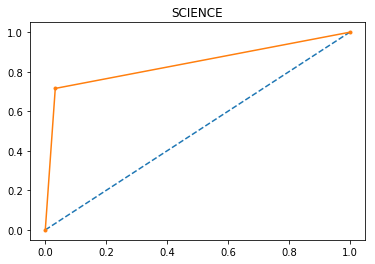

<class 'numpy.ndarray'>
[1.         0.71579344 0.        ]
<class 'numpy.ndarray'>
[0.23073578 0.86751942 1.        ]


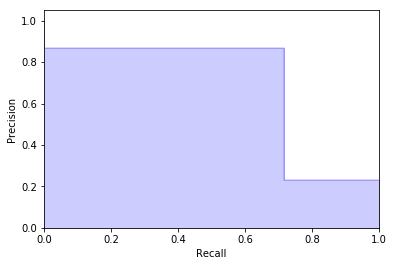

AUC: 0.834


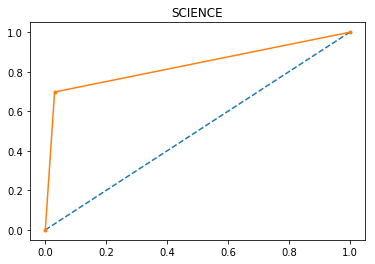

<class 'numpy.ndarray'>
[1.         0.69770072 0.        ]
<class 'numpy.ndarray'>
[0.23073578 0.87270156 1.        ]


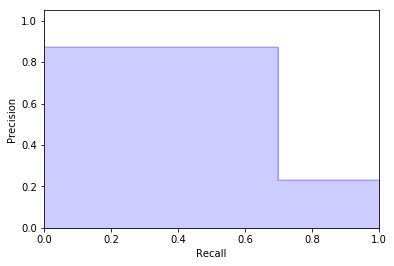

TRAIN: [24984 10558 10995 ...   609  8483 12210] TEST: [23212 22191 20015 ... 19767 24476 14857]
TRAIN: [18493  1877  7421 ... 19491  8961 17558] TEST: [11742   300  6014 ... 18153  8133 19345]
TRAIN: [17165  4837 26025 ... 21576 18177 15205] TEST: [11332  5458  5814 ... 25421 12743  5583]
TRAIN: [15643 13195 13056 ... 12681 17391 18158] TEST: [24815  2544 13635 ...  7318 15689 16061]
TRAIN: [14020  6802   327 ...  9449 20954  9232] TEST: [12509 12223 18107 ...  3411 22723 16605]
AUC: 0.872


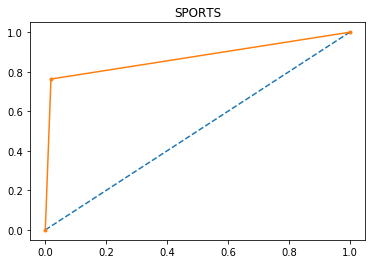

<class 'numpy.ndarray'>
[1.         0.76325524 0.        ]
<class 'numpy.ndarray'>
[0.23081302 0.9248008  1.        ]


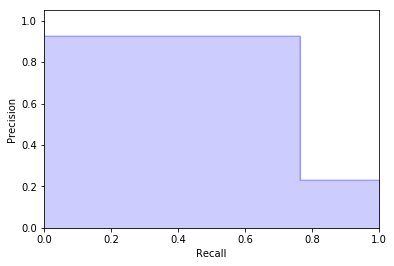

AUC: 0.867


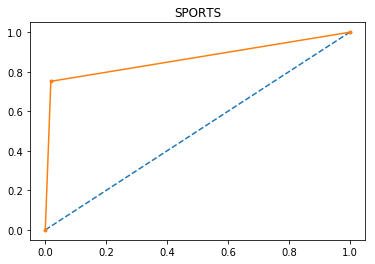

<class 'numpy.ndarray'>
[1.         0.75174681 0.        ]
<class 'numpy.ndarray'>
[0.23081302 0.9251391  1.        ]


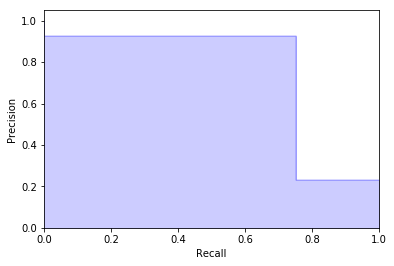

TRAIN: [10876 11234  9254 ... 11570 11349  5521] TEST: [ 8324 12543  7506 ...  1844  5274   885]
TRAIN: [ 9696 13943  2453 ...  5545 10193  6188] TEST: [ 8413  7509 14974 ...  7885  7029  1883]
TRAIN: [ 8129  8859 11655 ...  6400  5068  1409] TEST: [10818 14878 13955 ... 12586  6332  3563]
TRAIN: [3421 8267   60 ... 6751 5363 2634] TEST: [  115  1149  1733 ... 10286  5375  7730]
TRAIN: [ 8406 13665  6187 ...  8537 11032  7549] TEST: [ 5953  9613 14805 ...  9767 10768 11474]
AUC: 0.739


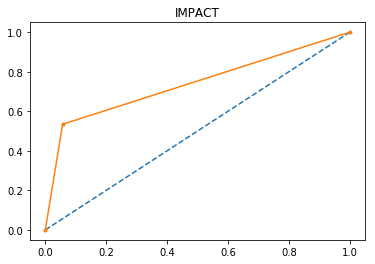

<class 'numpy.ndarray'>
[1.         0.53468208 0.        ]
<class 'numpy.ndarray'>
[0.23082055 0.73778664 1.        ]


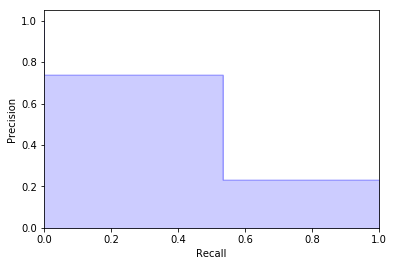

AUC: 0.738


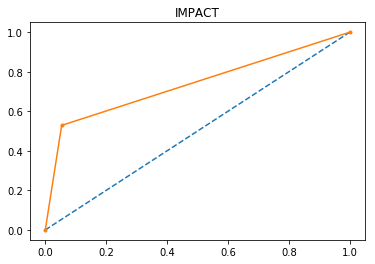

<class 'numpy.ndarray'>
[1.         0.52890173 0.        ]
<class 'numpy.ndarray'>
[0.23082055 0.74693878 1.        ]


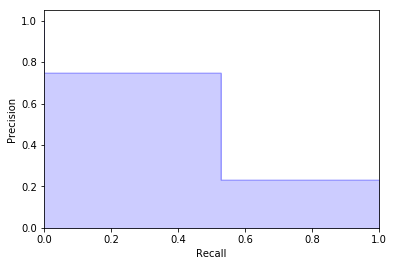

In [6]:
from matplotlib import pyplot

from sklearn.preprocessing import LabelEncoder
from sklearn.svm import LinearSVC

dataset50 = {"SCIENCE": df_science, "SPORTS": df_sport, "IMPACT": df_impact}


for key, df in dataset50.items():
    #splitting data
    split_map_all = split_dataset(df)
    X_train_all = split_map_all['X_train']
    y_train_all = split_map_all['y_train']
    X_test_all = split_map_all['X_test']
    y_test_all = split_map_all['y_test']

    #encoding label
    integer_encoded_train = y_train_all.replace("NONE", 0).replace(key, 1)
    integer_encoded_test = y_test_all.replace("NONE", 0).replace(key, 1)
#    label_encoder = MyLabelEncoder()
#    label_encoder.fit(["NONE", key])
#    integer_encoded_train = label_encoder.transform(y_train_all)
#    integer_encoded_test = label_encoder.transform(y_test_all)
#    print("0: "+ label_encoder.inverse_transform(0))
#    print("1: "+ label_encoder.inverse_transform(1))    
#    print(y_train_all.unique())
#    print(integer_encoded_test[:20])
    
    tfidf_vectorizer =  TfidfVectorizer(stop_words='english', max_df=0.15, min_df=5)
    X_train = tfidf_vectorizer.fit_transform(X_train_all)
    X_test = tfidf_vectorizer.transform(X_test_all)
    
    from sklearn.decomposition import TruncatedSVD
    svd = TruncatedSVD(n_components=2500, n_iter=4, random_state=42)    # there are 52120 features
    X_train_SVD = svd.fit_transform(X_train)
    X_test_SVD = svd.transform(X_test)

    svc = LinearSVC(C=0.5)
    
    
#    print(integer_encoded_train)
    svc.fit(X_train, integer_encoded_train)
    probs = svc.predict(X_test)

    print_AUC(integer_encoded_test, probs, key)
    print_prec_rec(integer_encoded_test, probs)
    
    svc.fit(X_train_SVD, integer_encoded_train)
    probs_SVD = svc.predict(X_test_SVD)

    print_AUC(integer_encoded_test, probs_SVD, key)
    print_prec_rec(integer_encoded_test, probs_SVD)

TRAIN: [ 9975   478 11889 ... 19803 27559 27463] TEST: [19232  8195 25501 ... 14809 26032 23200]
TRAIN: [11105 25912 11690 ... 18426 20577 19001] TEST: [ 4072 14504 23642 ...  9782  3363  4826]
TRAIN: [25957  7494 14539 ... 13265 21465  1473] TEST: [28103 17290 23674 ...   528 10190 15578]
TRAIN: [ 4638  4038  9709 ... 27775  9766  6430] TEST: [18428  8819 13639 ... 23460  5780  6300]
TRAIN: [ 9533  3232  9240 ... 27884  7049 25753] TEST: [22600 14826 25084 ...  7760 10021 21877]
AUC: 0.842


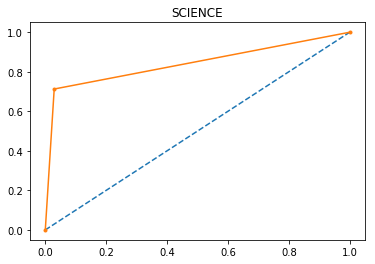

<class 'numpy.ndarray'>
[1.         0.71277799 0.        ]
<class 'numpy.ndarray'>
[0.23073578 0.87953488 1.        ]


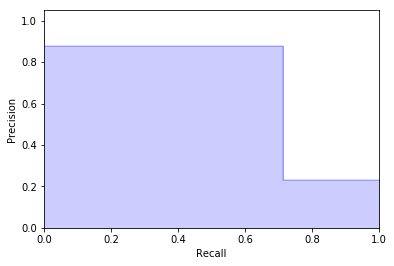

AUC: 0.838


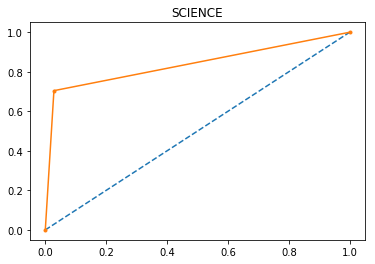

<class 'numpy.ndarray'>
[1.         0.70448549 0.        ]
<class 'numpy.ndarray'>
[0.23073578 0.88160377 1.        ]


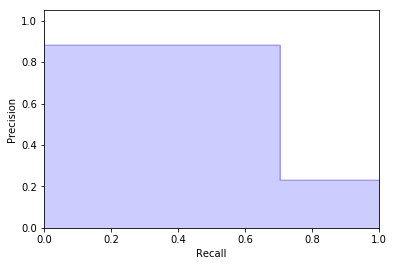

TRAIN: [24984 10558 10995 ...   609  8483 12210] TEST: [23212 22191 20015 ... 19767 24476 14857]
TRAIN: [18493  1877  7421 ... 19491  8961 17558] TEST: [11742   300  6014 ... 18153  8133 19345]
TRAIN: [17165  4837 26025 ... 21576 18177 15205] TEST: [11332  5458  5814 ... 25421 12743  5583]
TRAIN: [15643 13195 13056 ... 12681 17391 18158] TEST: [24815  2544 13635 ...  7318 15689 16061]
TRAIN: [14020  6802   327 ...  9449 20954  9232] TEST: [12509 12223 18107 ...  3411 22723 16605]
AUC: 0.874


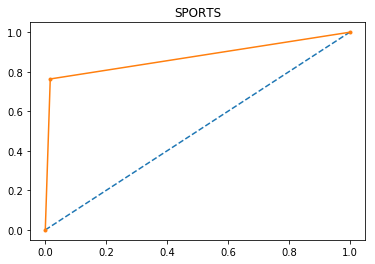

<class 'numpy.ndarray'>
[1.         0.76366626 0.        ]
<class 'numpy.ndarray'>
[0.23081302 0.93366834 1.        ]


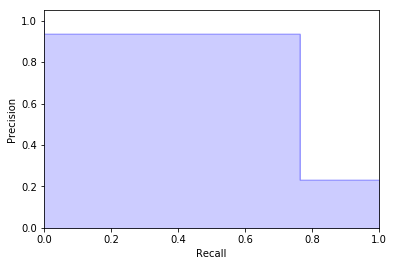

AUC: 0.869


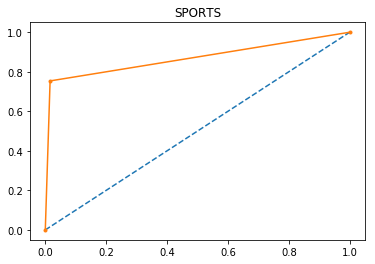

<class 'numpy.ndarray'>
[1.         0.75380189 0.        ]
<class 'numpy.ndarray'>
[0.23081302 0.93476045 1.        ]


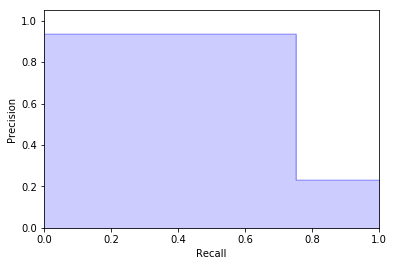

TRAIN: [10876 11234  9254 ... 11570 11349  5521] TEST: [ 8324 12543  7506 ...  1844  5274   885]
TRAIN: [ 9696 13943  2453 ...  5545 10193  6188] TEST: [ 8413  7509 14974 ...  7885  7029  1883]
TRAIN: [ 8129  8859 11655 ...  6400  5068  1409] TEST: [10818 14878 13955 ... 12586  6332  3563]
TRAIN: [3421 8267   60 ... 6751 5363 2634] TEST: [  115  1149  1733 ... 10286  5375  7730]
TRAIN: [ 8406 13665  6187 ...  8537 11032  7549] TEST: [ 5953  9613 14805 ...  9767 10768 11474]
AUC: 0.745


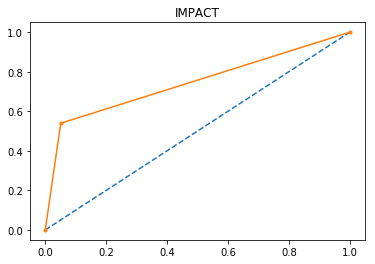

<class 'numpy.ndarray'>
[1.         0.53973988 0.        ]
<class 'numpy.ndarray'>
[0.23082055 0.76146789 1.        ]


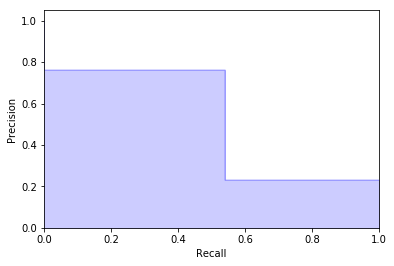

AUC: 0.738


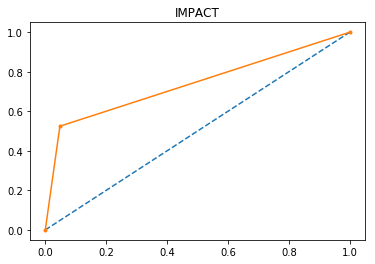

<class 'numpy.ndarray'>
[1.         0.52456647 0.        ]
<class 'numpy.ndarray'>
[0.23082055 0.76663147 1.        ]


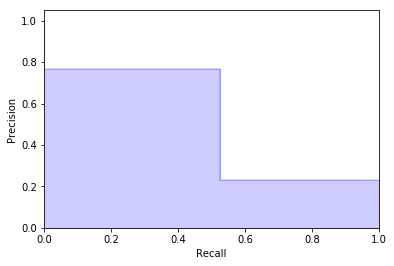

In [18]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot

from sklearn.metrics import precision_recall_curve
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import LinearSVC

dataset50 = {"SCIENCE": df_science, "SPORTS": df_sport, "IMPACT": df_impact}


for key, df in dataset50.items():
    #splitting data
    split_map_all = split_dataset(df)
    X_train_all = split_map_all['X_train']
    y_train_all = split_map_all['y_train']
    X_test_all = split_map_all['X_test']
    y_test_all = split_map_all['y_test']

    #encoding label
    integer_encoded_train = y_train_all.replace("NONE", 0).replace(key, 1)
    integer_encoded_test = y_test_all.replace("NONE", 0).replace(key, 1)
#    label_encoder = MyLabelEncoder()
#    label_encoder.fit(["NONE", key])
#    integer_encoded_train = label_encoder.transform(y_train_all)
#    integer_encoded_test = label_encoder.transform(y_test_all)
#    print("0: "+ label_encoder.inverse_transform(0))
#    print("1: "+ label_encoder.inverse_transform(1))    
#    print(y_train_all.unique())
#    print(integer_encoded_test[:20])
    
    tfidf_vectorizer =  TfidfVectorizer(stop_words='english', max_df=0.15, min_df=5)
    X_train = tfidf_vectorizer.fit_transform(X_train_all)
    X_test = tfidf_vectorizer.transform(X_test_all)
    
    from sklearn.decomposition import TruncatedSVD
    svd = TruncatedSVD(n_components=2500, n_iter=4, random_state=42)    # there are 52120 features
    X_train_SVD = svd.fit_transform(X_train)
    X_test_SVD = svd.transform(X_test)

    svc = LinearSVC(C=0.5)
    
    svc.fit(X_train, integer_encoded_train)
    probs = svc.predict(X_test)

    print_AUC(integer_encoded_test, probs, key)
    print_prec_rec(integer_encoded_test, probs)
    
    svc.fit(X_train_SVD, integer_encoded_train)
    probs_SVD = svc.predict(X_test_SVD)

    print_AUC(integer_encoded_test, probs_SVD, key)
    print_prec_rec(integer_encoded_test, probs_SVD)

In [ ]:
dataset25 = {"POLITICS": df_politics, "LIFESTYLE": df_lifestyle, "HEALTH": df_health, "EDUCATION": df_education, "WORLDPOST": df_worldpost, "BUSINESS": df_business, "RANDOM": df_random}

for key, df in dataset25.items():
    #splitting data
    split_map_all = split_dataset(df)
    X_train_all = split_map_all['X_train']
    y_train_all = split_map_all['y_train']
    X_test_all = split_map_all['X_test']
    y_test_all = split_map_all['y_test']

    #encoding label
    integer_encoded_train = y_train_all.replace("NONE", 0).replace(key, 1)
    integer_encoded_test = y_test_all.replace("NONE", 0).replace(key, 1)
#    label_encoder = MyLabelEncoder()
#    label_encoder.fit(["NONE", key])
#    integer_encoded_train = label_encoder.transform(y_train_all)
#    integer_encoded_test = label_encoder.transform(y_test_all)
#    print("0: "+ label_encoder.inverse_transform(0))
#    print("1: "+ label_encoder.inverse_transform(1))    
#    print(y_train_all.unique())
#    print(integer_encoded_test[:20])
    
    tfidf_vectorizer =  TfidfVectorizer(stop_words='english', max_df=0.15, min_df=5)
    X_train = tfidf_vectorizer.fit_transform(X_train_all)
    X_test = tfidf_vectorizer.transform(X_test_all)
    
    from sklearn.decomposition import TruncatedSVD
    svd = TruncatedSVD(n_components=2500, n_iter=4, random_state=42)    # there are 52120 features
    X_train_SVD = svd.fit_transform(X_train)
    X_test_SVD = svd.transform(X_test)

    svc = LinearSVC(C=0.5)
    
    svc.fit(X_train, integer_encoded_train)
    probs = svc.predict(X_test)

    print_AUC(integer_encoded_test, probs, key)
    print_prec_rec(integer_encoded_test, probs)
    
    svc.fit(X_train_SVD, integer_encoded_train)
    probs_SVD = svc.predict(X_test_SVD)

    print_AUC(integer_encoded_test, probs_SVD, key)
    print_prec_rec(integer_encoded_test, probs_SVD)

# determine parameters (Logistic Regression)

In [25]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression

pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words='english', min_df=5)),
    ('logReg', LogisticRegression()),
])

# work with 10%
parameters_pipeline = {
    'tfidf__max_df': (0.15, 0.25),
    'logReg__C': [0.1, 0.25, 0.5, 1, 5, 10],
}

grid_search = GridSearchCV(pipeline, parameters_pipeline, n_jobs=-1, cv=3)

for key, df in datasets.items():
    print("Dataset: "+key)
    
    #splitting data
    split_map_all = split_dataset(df)
    X_train_all = split_map_all['X_train']
    y_train_all = split_map_all['y_train']
    X_test_all = split_map_all['X_test']
    y_test_all = split_map_all['y_test']

    #encoding label
    integer_encoded_train = y_train_all.replace("NONE", 0).replace(key, 1)
    integer_encoded_test = y_test_all.replace("NONE", 0).replace(key, 1)
#    label_encoder = MyLabelEncoder()
#    label_encoder.fit(["NONE", key])
#    integer_encoded_train = label_encoder.transform(y_train_all)
#    integer_encoded_test = label_encoder.transform(y_test_all)
#    print("0: "+ label_encoder.inverse_transform(0))
#    print("1: "+ label_encoder.inverse_transform(1))    
#    print(y_train_all.unique())
#    print(integer_encoded_test[:20])

    grid_search.fit(X_train_all, integer_encoded_train)

    print(grid_search.best_params_)
    print(grid_search.best_score_)
    pipeline_best = grid_search.best_estimator_
    accuracy = pipeline_best.score(X_test_all, integer_encoded_test)
    print('The accuracy on testing set is: {0:.1f}%'.format(accuracy*100))

Dataset: SCIENCE
TRAIN: [ 9975   478 11889 ... 19803 27559 27463] TEST: [19232  8195 25501 ... 14809 26032 23200]
TRAIN: [11105 25912 11690 ... 18426 20577 19001] TEST: [ 4072 14504 23642 ...  9782  3363  4826]
TRAIN: [25957  7494 14539 ... 13265 21465  1473] TEST: [28103 17290 23674 ...   528 10190 15578]
TRAIN: [ 4638  4038  9709 ... 27775  9766  6430] TEST: [18428  8819 13639 ... 23460  5780  6300]
TRAIN: [ 9533  3232  9240 ... 27884  7049 25753] TEST: [22600 14826 25084 ...  7760 10021 21877]
0: NONE
1: SCIENCE


C:\Users\Max\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Max\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


{'logReg__C': 5, 'tfidf__max_df': 0.15}
0.9039141780226152
The accuracy on testing set is: 90.6%
Dataset: SPORTS
TRAIN: [24984 10558 10995 ...   609  8483 12210] TEST: [23212 22191 20015 ... 19767 24476 14857]
TRAIN: [18493  1877  7421 ... 19491  8961 17558] TEST: [11742   300  6014 ... 18153  8133 19345]
TRAIN: [17165  4837 26025 ... 21576 18177 15205] TEST: [11332  5458  5814 ... 25421 12743  5583]
TRAIN: [15643 13195 13056 ... 12681 17391 18158] TEST: [24815  2544 13635 ...  7318 15689 16061]
TRAIN: [14020  6802   327 ...  9449 20954  9232] TEST: [12509 12223 18107 ...  3411 22723 16605]
0: NONE
1: SPORTS


C:\Users\Max\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Max\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


{'logReg__C': 10, 'tfidf__max_df': 0.15}
0.9304237824161923
The accuracy on testing set is: 93.2%
Dataset: POLITICS
TRAIN: [101684 103576 122187 ...  15374   7845 131736] TEST: [ 50312 131837  81378 ...  59289  41766 125319]
TRAIN: [ 38886  19447 128828 ...  52868 131490  33832] TEST: [ 65197  25274  29430 ... 108403  61728  15489]
TRAIN: [ 79968  48573  72398 ...  95446 125260 120559] TEST: [ 99474 107105  18029 ...  84102  87575  61776]
TRAIN: [ 85378  62120  86993 ... 103919  49241 124957] TEST: [ 23709 126057  93346 ... 116051  12253 117520]
TRAIN: [ 28357  74722  39288 ...   9031 115431   3798] TEST: [ 79614  70070  50413 ...   8440 109355  26987]
0: NONE
1: POLITICS


C:\Users\Max\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Max\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


{'logReg__C': 5, 'tfidf__max_df': 0.15}
0.882911195081497
The accuracy on testing set is: 89.0%
Dataset: LIFESTYLE
TRAIN: [ 11766 120575  53223 ...   9141 133011 108463] TEST: [  3043  49881  40769 ...  86787 122507 124754]
TRAIN: [ 98516 115212  36958 ...  98860  43558  91753] TEST: [ 78686  63711  60282 ...  13869  95691 129873]
TRAIN: [ 81429  73379 122998 ... 119414 132273 107802] TEST: [ 31392 118638  84167 ...  77002  15306 111746]
TRAIN: [ 16596 122047  60481 ...  13159  62726  42332] TEST: [ 81613  65986  43134 ... 113402  77783  17324]
TRAIN: [  8865 120375  31225 ... 131784 121872  32651] TEST: [ 81198 118972  62644 ... 112998  89424  33855]
0: LIFESTYLE
1: NONE


C:\Users\Max\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Max\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


{'logReg__C': 5, 'tfidf__max_df': 0.15}
0.8661753152007183
The accuracy on testing set is: 87.1%
Dataset: HEALTH
TRAIN: [24380 30349 30868 ... 20840 16216 27998] TEST: [ 4385  6438  2251 ... 10102  8276 17359]
TRAIN: [14739 34432 23259 ... 16257 22504 13086] TEST: [26691  6363 23256 ... 12558 24166 28517]
TRAIN: [37418 17836 16918 ...  1754  1883 24624] TEST: [36218  1657 18216 ...  9267 17278 32609]
TRAIN: [22134 33916 38161 ... 34035 12682 36178] TEST: [24011  7193 32678 ... 27254 13967  8582]
TRAIN: [33839 16006  6256 ... 32835 16015  9947] TEST: [ 6419 36085 40016 ... 32947  3917  2583]
0: HEALTH
1: NONE


C:\Users\Max\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Max\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


{'logReg__C': 5, 'tfidf__max_df': 0.15}
0.8578152093138469
The accuracy on testing set is: 85.9%
Dataset: EDUCATION
TRAIN: [1360 4858 1938 ... 6446 3763 4206] TEST: [7263 1133 7921 ... 2501 6644 5689]
TRAIN: [1176 5669 3607 ... 8097 2304 1253] TEST: [8150 3356 4949 ... 6984 4590 3247]
TRAIN: [3148 4014 6436 ... 4461 6410 6868] TEST: [3981 7730  786 ... 1564 2850 5575]
TRAIN: [6676 5604 3910 ... 3499 9155 7561] TEST: [ 286  887 3276 ... 1123 6301 6295]
TRAIN: [2422 2175  762 ...  613 6728 4123] TEST: [8690 8939 5100 ... 7877 1550 3293]
0: EDUCATION
1: NONE


C:\Users\Max\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Max\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


{'logReg__C': 5, 'tfidf__max_df': 0.15}
0.8959527220630372
The accuracy on testing set is: 90.9%
Dataset: WORLDPOST
TRAIN: [30851 22579  4469 ... 18791 20562 11705] TEST: [13795 25968 32238 ... 19664 16511  6893]
TRAIN: [31521 26610 35972 ... 11659  4364 34572] TEST: [30515   450 13471 ... 15369 11206  5765]
TRAIN: [ 2953 18928  8881 ... 26617 11679 30877] TEST: [20973 25372 34697 ... 15163  2796 19308]
TRAIN: [26222 10734 13957 ... 34401 18348  7771] TEST: [32703 34412 16568 ... 22399 16909  5806]
TRAIN: [32499  1589  1854 ... 15429  6380 35341] TEST: [34632  6533 15073 ... 36352  6323 19383]
0: NONE
1: WORLDPOST


C:\Users\Max\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Max\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


{'logReg__C': 5, 'tfidf__max_df': 0.15}
0.8929289238077837
The accuracy on testing set is: 90.2%
Dataset: IMPACT
TRAIN: [10876 11234  9254 ... 11570 11349  5521] TEST: [ 8324 12543  7506 ...  1844  5274   885]
TRAIN: [ 9696 13943  2453 ...  5545 10193  6188] TEST: [ 8413  7509 14974 ...  7885  7029  1883]
TRAIN: [ 8129  8859 11655 ...  6400  5068  1409] TEST: [10818 14878 13955 ... 12586  6332  3563]
TRAIN: [3421 8267   60 ... 6751 5363 2634] TEST: [  115  1149  1733 ... 10286  5375  7730]
TRAIN: [ 8406 13665  6187 ...  8537 11032  7549] TEST: [ 5953  9613 14805 ...  9767 10768 11474]
0: IMPACT
1: NONE


C:\Users\Max\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Max\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


{'logReg__C': 5, 'tfidf__max_df': 0.15}
0.8445457578116312
The accuracy on testing set is: 84.8%
Dataset: BUSINESS
TRAIN: [11484  2118 24686 ...  2735  8506  4392] TEST: [12039 25702  6904 ...  8692 24719  7559]
TRAIN: [14457 16569 23881 ... 12039 22933 22274] TEST: [17950 24819  7056 ... 25588 16344  5436]
TRAIN: [24002 14435  3437 ...  3749 13487  1870] TEST: [18756 25100  1624 ... 22682 11641  2782]
TRAIN: [24699  9250 20003 ... 19504   992 25249] TEST: [ 9436 25542 20086 ... 20350 17787 22006]
TRAIN: [ 3549  4145 21283 ... 13041 19055 23901] TEST: [ 1751 15567 21361 ... 18149 16027  6620]
0: BUSINESS
1: NONE


C:\Users\Max\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Max\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


{'logReg__C': 5, 'tfidf__max_df': 0.15}
0.8664809536149262
The accuracy on testing set is: 86.9%
Dataset: RANDOM
TRAIN: [39590 22057 22832 ... 22634 31964 21909] TEST: [61766 32181 62091 ... 51162 60346 29189]
TRAIN: [14896 42612 66750 ... 53120 30097 31991] TEST: [65206 59254 28344 ... 63361 22844 19645]
TRAIN: [15280 58392 32956 ... 30415 36594 24651] TEST: [ 5580 66440 45107 ... 43723 64320 45342]
TRAIN: [52454  5203 70427 ... 51809 58508 21566] TEST: [11368 28117 40263 ... 47091 38864 23256]
TRAIN: [28813 46597 44871 ... 19144 54096 48946] TEST: [ 5112 64579 19060 ... 67515 36206 13796]
0: NONE
1: RANDOM


C:\Users\Max\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Max\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


{'logReg__C': 5, 'tfidf__max_df': 0.15}
0.8352100172872962
The accuracy on testing set is: 84.2%


TRAIN: [ 9975   478 11889 ... 19803 27559 27463] TEST: [19232  8195 25501 ... 14809 26032 23200]
TRAIN: [11105 25912 11690 ... 18426 20577 19001] TEST: [ 4072 14504 23642 ...  9782  3363  4826]
TRAIN: [25957  7494 14539 ... 13265 21465  1473] TEST: [28103 17290 23674 ...   528 10190 15578]
TRAIN: [ 4638  4038  9709 ... 27775  9766  6430] TEST: [18428  8819 13639 ... 23460  5780  6300]
TRAIN: [ 9533  3232  9240 ... 27884  7049 25753] TEST: [22600 14826 25084 ...  7760 10021 21877]
AUC: 0.944


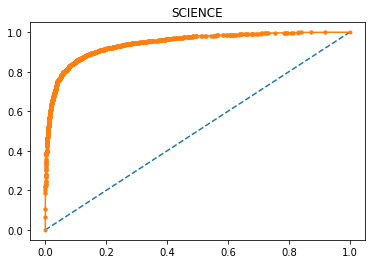

<class 'numpy.ndarray'>
[1.00000000e+00 9.99623068e-01 9.99623068e-01 ... 7.53863551e-04
 3.76931775e-04 0.00000000e+00]
<class 'numpy.ndarray'>
[0.24587581 0.24580591 0.2458287  ... 1.         1.         1.        ]


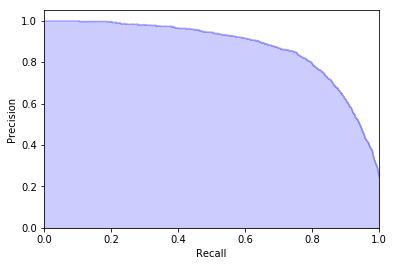

0.1
F1 Score (macro, micro, weighted): 
0.7629981939125828
0.7944859975647939
0.8095199023865726
0.2
F1 Score (macro, micro, weighted): 
0.8410199033144936
0.8769351191511567
0.8817128614957597
0.3
F1 Score (macro, micro, weighted): 
0.8644385445565785
0.9020699252043833
0.90290231295724
0.4
F1 Score (macro, micro, weighted): 
0.8693597729401121
0.9104192033397113
0.9088012859767735
0.5
F1 Score (macro, micro, weighted): 
0.8572303969165194
0.9061575926248043
0.9022396371223879
0.6
F1 Score (macro, micro, weighted): 
0.8416184692939042
0.9000695773177944
0.8934336820188761
0.7
F1 Score (macro, micro, weighted): 
0.8181707028858292
0.8898069229431206
0.8796327334518188
TRAIN: [24984 10558 10995 ...   609  8483 12210] TEST: [23212 22191 20015 ... 19767 24476 14857]
TRAIN: [18493  1877  7421 ... 19491  8961 17558] TEST: [11742   300  6014 ... 18153  8133 19345]
TRAIN: [17165  4837 26025 ... 21576 18177 15205] TEST: [11332  5458  5814 ... 25421 12743  5583]
TRAIN: [15643 13195 13056 ... 12

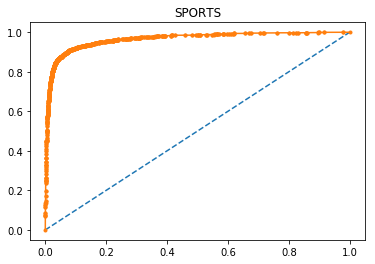

<class 'numpy.ndarray'>
[1.00000000e+00 9.99588985e-01 9.99588985e-01 ... 8.22030415e-04
 4.11015208e-04 0.00000000e+00]
<class 'numpy.ndarray'>
[0.23480023 0.23472638 0.23474903 ... 1.         1.         1.        ]


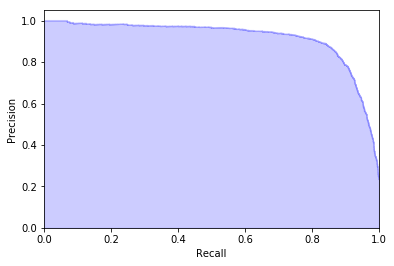

0.1
F1 Score (macro, micro, weighted): 
0.8156291707863212
0.8461246561047339
0.8559981652304528
0.2
F1 Score (macro, micro, weighted): 
0.8931989931725053
0.9203111659235368
0.9221693528716397
0.3
F1 Score (macro, micro, weighted): 
0.9110415022658462
0.9370078740157481
0.9369166839481452
0.4
F1 Score (macro, micro, weighted): 
0.9079228843881761
0.9371027416753629
0.9358291348271354
0.5
F1 Score (macro, micro, weighted): 
0.8939068749700776
0.9297979318850204
0.9271284942805165
0.6
F1 Score (macro, micro, weighted): 
0.8725018906000732
0.9185086803908548
0.9137350763332831
0.7
F1 Score (macro, micro, weighted): 
0.8443654207140916
0.9041836637890144
0.8963116379214652
TRAIN: [101684 103576 122187 ...  15374   7845 131736] TEST: [ 50312 131837  81378 ...  59289  41766 125319]
TRAIN: [ 38886  19447 128828 ...  52868 131490  33832] TEST: [ 65197  25274  29430 ... 108403  61728  15489]
TRAIN: [ 79968  48573  72398 ...  95446 125260 120559] TEST: [ 99474 107105  18029 ...  84102  87575  6

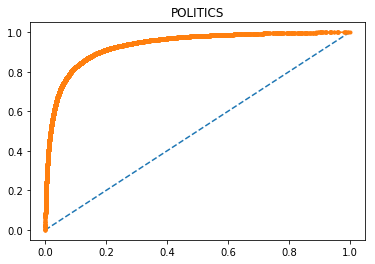

<class 'numpy.ndarray'>
[1.00000000e+00 9.99927146e-01 9.99927146e-01 ... 1.45708874e-04
 7.28544368e-05 0.00000000e+00]
<class 'numpy.ndarray'>
[0.25946089 0.25944689 0.2594518  ... 1.         1.         1.        ]


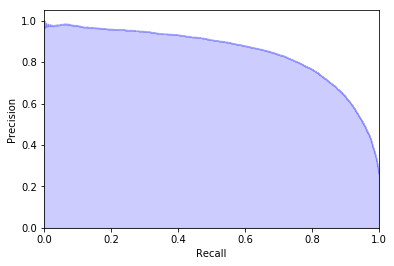

0.1
F1 Score (macro, micro, weighted): 
0.7608772234014514
0.7824501019472867
0.7958181122562522
0.2
F1 Score (macro, micro, weighted): 
0.8275951959640021
0.8556837950578949
0.861449130371031
0.3
F1 Score (macro, micro, weighted): 
0.847842895916348
0.8793280832039507
0.8815148782252832
0.4
F1 Score (macro, micro, weighted): 
0.8523637364663663
0.8878953964720627
0.8875986896337631
0.5
F1 Score (macro, micro, weighted): 
0.8485984584511506
0.8891299874670308
0.8867077670236739
0.6
F1 Score (macro, micro, weighted): 
0.836173236314027
0.8846031538188144
0.8795062324107381
0.7
F1 Score (macro, micro, weighted): 
0.8149979942747223
0.8749883087973961
0.866248507046261
TRAIN: [ 11766 120575  53223 ...   9141 133011 108463] TEST: [  3043  49881  40769 ...  86787 122507 124754]
TRAIN: [ 98516 115212  36958 ...  98860  43558  91753] TEST: [ 78686  63711  60282 ...  13869  95691 129873]
TRAIN: [ 81429  73379 122998 ... 119414 132273 107802] TEST: [ 31392 118638  84167 ...  77002  15306 111746

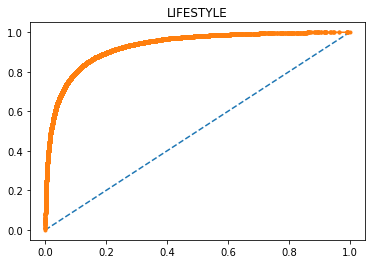

<class 'numpy.ndarray'>
[1.00000000e+00 9.99938838e-01 9.99938838e-01 ... 1.22324159e-04
 6.11620795e-05 0.00000000e+00]
<class 'numpy.ndarray'>
[0.30747532 0.30746229 0.30746808 ... 1.         1.         1.        ]


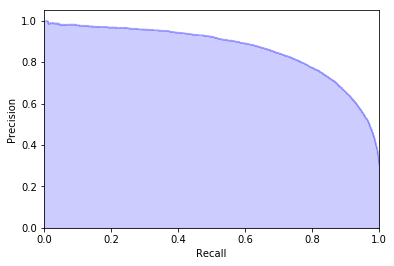

0.1
F1 Score (macro, micro, weighted): 
0.7383699781842922
0.7451691950840831
0.7547479015566246
0.2
F1 Score (macro, micro, weighted): 
0.8096976759596506
0.823771488430386
0.8297938565264407
0.3
F1 Score (macro, micro, weighted): 
0.837210765305181
0.8553845002712359
0.8583320599060281
0.4
F1 Score (macro, micro, weighted): 
0.845422260662745
0.8676742924484184
0.8681965015461841
0.5
F1 Score (macro, micro, weighted): 
0.843700907088825
0.8712284180399932
0.8691719835245416
0.6
F1 Score (macro, micro, weighted): 
0.8315881201610137
0.8664397014534503
0.8613378621754754
0.7
F1 Score (macro, micro, weighted): 
0.8086955286439437
0.854561439607924
0.8450697052064919
TRAIN: [24380 30349 30868 ... 20840 16216 27998] TEST: [ 4385  6438  2251 ... 10102  8276 17359]
TRAIN: [14739 34432 23259 ... 16257 22504 13086] TEST: [26691  6363 23256 ... 12558 24166 28517]
TRAIN: [37418 17836 16918 ...  1754  1883 24624] TEST: [36218  1657 18216 ...  9267 17278 32609]
TRAIN: [22134 33916 38161 ... 34035

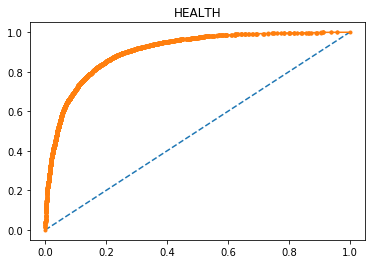

<class 'numpy.ndarray'>
[1.00000000e+00 9.99731616e-01 9.99731616e-01 ... 5.36768653e-04
 2.68384326e-04 0.00000000e+00]
<class 'numpy.ndarray'>
[0.23843348 0.23838474 0.2384     ... 1.         1.         1.        ]


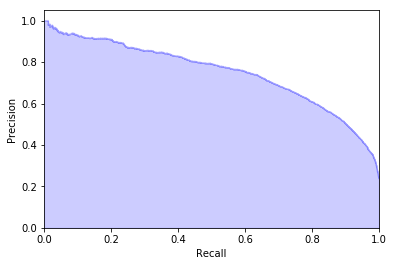

0.1
F1 Score (macro, micro, weighted): 
0.7003666600714661
0.7269630914045084
0.7484403592758175
0.2
F1 Score (macro, micro, weighted): 
0.7761808784046724
0.8177483279663116
0.8281237640761789
0.3
F1 Score (macro, micro, weighted): 
0.7983954316484281
0.849021550656428
0.8528003662620672
0.4
F1 Score (macro, micro, weighted): 
0.8001574339180126
0.8608496408223929
0.8594651573971104
0.5
F1 Score (macro, micro, weighted): 
0.7879781581207703
0.8620881842952688
0.8554821685547744
0.6
F1 Score (macro, micro, weighted): 
0.7599484445178804
0.8539137973742879
0.8408276594480317
0.7
F1 Score (macro, micro, weighted): 
0.7244188359521078
0.8430765419866237
0.8217996788811519
TRAIN: [1360 4858 1938 ... 6446 3763 4206] TEST: [7263 1133 7921 ... 2501 6644 5689]
TRAIN: [1176 5669 3607 ... 8097 2304 1253] TEST: [8150 3356 4949 ... 6984 4590 3247]
TRAIN: [3148 4014 6436 ... 4461 6410 6868] TEST: [3981 7730  786 ... 1564 2850 5575]
TRAIN: [6676 5604 3910 ... 3499 9155 7561] TEST: [ 286  887 3276 ..

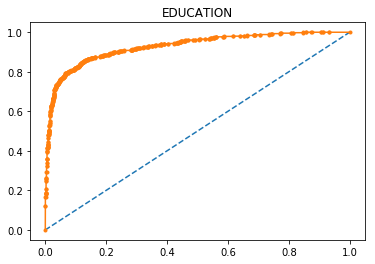

<class 'numpy.ndarray'>
[1.         0.99883586 0.99883586 ... 0.00232829 0.00116414 0.        ]
<class 'numpy.ndarray'>
[0.25959504 0.25937122 0.25944965 ... 1.         1.         1.        ]


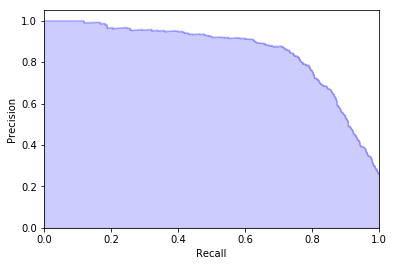

0.1
F1 Score (macro, micro, weighted): 
0.7299163023752602
0.7612781954887218
0.779492313081016
0.2
F1 Score (macro, micro, weighted): 
0.8352760516034865
0.8740601503759399
0.8783313377891763
0.3
F1 Score (macro, micro, weighted): 
0.859985353158879
0.9011815252416756
0.9008960072173394
0.4
F1 Score (macro, micro, weighted): 
0.865231259968102
0.9092373791621912
0.9067144719527556
0.5
F1 Score (macro, micro, weighted): 
0.8538372738146291
0.9049409237379162
0.900392188322401
0.6
F1 Score (macro, micro, weighted): 
0.8391691798205231
0.8990332975295381
0.8920245583963523
0.7
F1 Score (macro, micro, weighted): 
0.8088946737391125
0.8848012889366272
0.8737726754801498
TRAIN: [30851 22579  4469 ... 18791 20562 11705] TEST: [13795 25968 32238 ... 19664 16511  6893]
TRAIN: [31521 26610 35972 ... 11659  4364 34572] TEST: [30515   450 13471 ... 15369 11206  5765]
TRAIN: [ 2953 18928  8881 ... 26617 11679 30877] TEST: [20973 25372 34697 ... 15163  2796 19308]
TRAIN: [26222 10734 13957 ... 3440

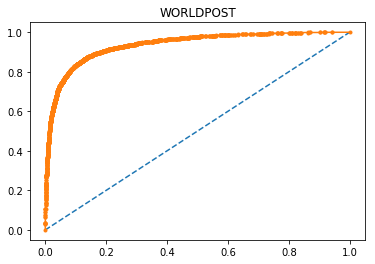

<class 'numpy.ndarray'>
[1.00000000e+00 9.99703088e-01 9.99703088e-01 ... 5.93824228e-04
 2.96912114e-04 0.00000000e+00]
<class 'numpy.ndarray'>
[0.24157223 0.24151783 0.24153515 ... 1.         1.         1.        ]


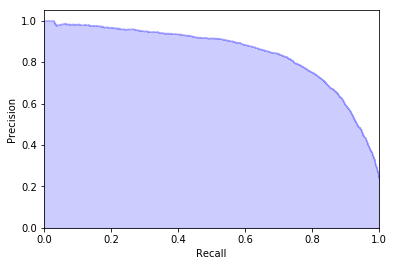

0.1
F1 Score (macro, micro, weighted): 
0.7580126565154621
0.7897910243233984
0.8052325832695877
0.2
F1 Score (macro, micro, weighted): 
0.8334292312550526
0.870777663583419
0.875900846024063
0.3
F1 Score (macro, micro, weighted): 
0.8520727472852592
0.8927029804727646
0.8938184660224281
0.4
F1 Score (macro, micro, weighted): 
0.854224476573203
0.8996916752312435
0.8980628662497507
0.5
F1 Score (macro, micro, weighted): 
0.8445786997765026
0.8975676601575883
0.8934451911676025
0.6
F1 Score (macro, micro, weighted): 
0.8270494675913491
0.8910585817060637
0.8837053553971316
0.7
F1 Score (macro, micro, weighted): 
0.8001178465559731
0.8803014731072285
0.8682878077271452
TRAIN: [10876 11234  9254 ... 11570 11349  5521] TEST: [ 8324 12543  7506 ...  1844  5274   885]
TRAIN: [ 9696 13943  2453 ...  5545 10193  6188] TEST: [ 8413  7509 14974 ...  7885  7029  1883]
TRAIN: [ 8129  8859 11655 ...  6400  5068  1409] TEST: [10818 14878 13955 ... 12586  6332  3563]
TRAIN: [3421 8267   60 ... 6751 5

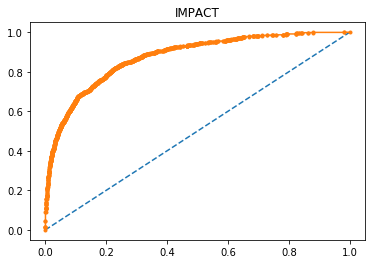

<class 'numpy.ndarray'>
[1.00000000e+00 9.99277457e-01 9.99277457e-01 ... 1.44508671e-03
 7.22543353e-04 0.00000000e+00]
<class 'numpy.ndarray'>
[0.23390232 0.23377282 0.23381234 ... 1.         1.         1.        ]


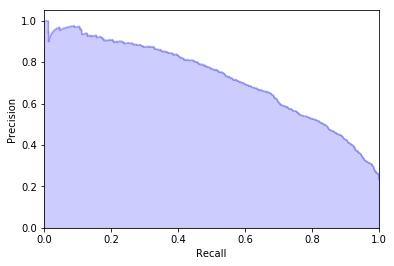

0.1
F1 Score (macro, micro, weighted): 
0.6525322673877789
0.6749499666444296
0.7000466030414023
0.2
F1 Score (macro, micro, weighted): 
0.7426127122896752
0.78685790527018
0.8000638317349968
0.3
F1 Score (macro, micro, weighted): 
0.7667769005376932
0.8255503669112741
0.8298070498579323
0.4
F1 Score (macro, micro, weighted): 
0.7749344464338364
0.8450633755837226
0.842569995670715
0.5
F1 Score (macro, micro, weighted): 
0.7649363668176042
0.8509006004002667
0.8414649233550657
0.6
F1 Score (macro, micro, weighted): 
0.7445411386596168
0.8480653769179453
0.8320905861570976
0.7
F1 Score (macro, micro, weighted): 
0.7049895448695527
0.8380587058038692
0.8116563567632635
TRAIN: [11484  2118 24686 ...  2735  8506  4392] TEST: [12039 25702  6904 ...  8692 24719  7559]
TRAIN: [14457 16569 23881 ... 12039 22933 22274] TEST: [17950 24819  7056 ... 25588 16344  5436]
TRAIN: [24002 14435  3437 ...  3749 13487  1870] TEST: [18756 25100  1624 ... 22682 11641  2782]
TRAIN: [24699  9250 20003 ... 195

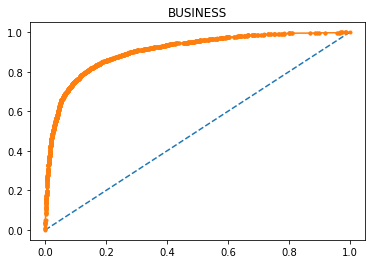

<class 'numpy.ndarray'>
[1.00000000e+00 9.99578947e-01 9.99578947e-01 ... 8.42105263e-04
 4.21052632e-04 0.00000000e+00]
<class 'numpy.ndarray'>
[0.23330059 0.23322527 0.23324818 ... 1.         1.         1.        ]


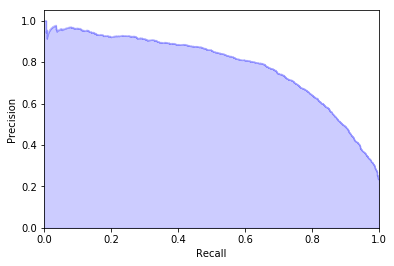

0.1
F1 Score (macro, micro, weighted): 
0.7025423681982709
0.7311242833543873
0.7521888860290047
0.2
F1 Score (macro, micro, weighted): 
0.7913741767765675
0.833932562433194
0.8421091197463109
0.3
F1 Score (macro, micro, weighted): 
0.8179250099265312
0.8672626566903119
0.8689572855879293
0.4
F1 Score (macro, micro, weighted): 
0.8221326487349765
0.8788261587795161
0.8762012785382113
0.5
F1 Score (macro, micro, weighted): 
0.8024603748355104
0.8736760275969294
0.866322801110154
0.6
F1 Score (macro, micro, weighted): 
0.7774867042728704
0.8659022446798174
0.8530085956548485
0.7
F1 Score (macro, micro, weighted): 
0.7465139016848565
0.855407637741716
0.8359698233291945
TRAIN: [39590 22057 22832 ... 22634 31964 21909] TEST: [61766 32181 62091 ... 51162 60346 29189]
TRAIN: [14896 42612 66750 ... 53120 30097 31991] TEST: [65206 59254 28344 ... 63361 22844 19645]
TRAIN: [15280 58392 32956 ... 30415 36594 24651] TEST: [ 5580 66440 45107 ... 43723 64320 45342]
TRAIN: [52454  5203 70427 ... 518

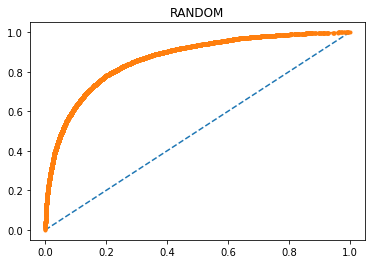

<class 'numpy.ndarray'>
[1.00000000e+00 9.99848163e-01 9.99848163e-01 ... 9.11023383e-04
 7.59186152e-04 0.00000000e+00]
<class 'numpy.ndarray'>
[0.23147758 0.23145056 0.2314587  ... 1.         1.         1.        ]


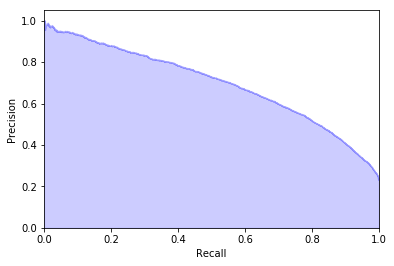

0.1
F1 Score (macro, micro, weighted): 
0.6520529663166438
0.6756955638096573
0.7008891207833255
0.2
F1 Score (macro, micro, weighted): 
0.738060251979369
0.7830261405844838
0.7964961319105426
0.3
F1 Score (macro, micro, weighted): 
0.7625917586502464
0.8213960333590301
0.8262111689984243
0.4
F1 Score (macro, micro, weighted): 
0.7654668060602317
0.8375849744200715
0.835493205745369
0.5
F1 Score (macro, micro, weighted): 
0.7555829151344279
0.8423155091457005
0.8339789762860287
0.6
F1 Score (macro, micro, weighted): 
0.7334433832382432
0.8396173523021936
0.8240252059375193
0.7
F1 Score (macro, micro, weighted): 
0.7003772645853421
0.8325741117107015
0.8075378867064791
SCIENCE


TypeError: bestValue() takes 0 positional arguments but 1 was given

In [26]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC

datasets_logReg = {"SCIENCE": df_science, "SPORTS": df_sport, "POLITICS": df_politics, "LIFESTYLE": df_lifestyle, "HEALTH": df_health, "EDUCATION": df_education, 
                   "WORLDPOST": df_worldpost, "IMPACT": df_impact, "BUSINESS": df_business, "RANDOM": df_random}


containerList = []

for key, df in datasets_logReg.items():
    #splitting data
    split_map_all = split_dataset(df)
    X_train_all = split_map_all['X_train']
    y_train_all = split_map_all['y_train']
    X_test_all = split_map_all['X_test']
    y_test_all = split_map_all['y_test']

    #encoding label
    integer_encoded_train = y_train_all.replace("NONE", 0).replace(key, 1)
    integer_encoded_test = y_test_all.replace("NONE", 0).replace(key, 1)
#    label_encoder = MyLabelEncoder()
#    label_encoder.fit(["NONE", key])
#    integer_encoded_train = label_encoder.transform(y_train_all)
#    integer_encoded_test = label_encoder.transform(y_test_all)
#    print("0: "+ label_encoder.inverse_transform(0))
#    print("1: "+ label_encoder.inverse_transform(1))    
#    print(y_train_all.unique())
#    print(integer_encoded_test[:20])
    
    tfidf_vectorizer =  TfidfVectorizer(stop_words='english', max_df=0.15, min_df=5)
    X_train = tfidf_vectorizer.fit_transform(X_train_all)
    X_test = tfidf_vectorizer.transform(X_test_all)
    
    from sklearn.decomposition import TruncatedSVD
    svd = TruncatedSVD(n_components=2500, n_iter=4, random_state=42)    # there are 52120 features
    X_train_SVD = svd.fit_transform(X_train)
    X_test_SVD = svd.transform(X_test)

    logReg = LogisticRegression(C=5)
    
    logReg.fit(X_train, integer_encoded_train)
    # predict probabilities
    #prob_bin = logReg.predict(X_test)
    probs = logReg.predict_proba(X_test)
    
    probabilities = convert_probability_list(probs)
    
    #print("Binary:")
    #print(prob_bin)
    #print("Probability:")
    #print(probabilities)

    print_AUC(integer_encoded_test, probabilities, key)
    print_prec_rec(integer_encoded_test, probabilities)
    
    f1_map = {}
    for i in range(1,8):
        thrashold = i/10.0
        print(thrashold)
        temp_prob = convert_probability_trueFalse(probabilities, thrashold)
        f1 = print_f1(integer_encoded_test, temp_prob)
        
        f1_map[thrashold] = f1
    
    container = ContainerForLabel(key, f1_map) 
    containerList.append(container)
    
#    svc = LinearSVC(C=0.5)
#    svc.fit(X_train_SVD, integer_encoded_train)
#    probs_SVD = svc.predict(X_test_SVD)

#    print_AUC(integer_encoded_test, probs_SVD, key)
#    print_prec_rec(integer_encoded_test, probs_SVD)

for item in containerList:
    print(item.name)
    print(item.bestValue())
    print("------------------------")

In [63]:
newList = []

for item in containerList:
    print(item.name)
    print(item.thrashold)
    newList.append(ContainerForLabel(item.name, item.thrashold))
    #print(item.bestValue())
    print("------------------------")

SCIENCE
{0.1: 0.7944859975647939, 0.2: 0.8769351191511567, 0.3: 0.9020699252043833, 0.4: 0.9104192033397113, 0.5: 0.9061575926248043, 0.6: 0.9000695773177944, 0.7: 0.8898069229431206}
------------------------
SPORTS
{0.1: 0.8461246561047339, 0.2: 0.9203111659235368, 0.3: 0.9370078740157481, 0.4: 0.9371027416753629, 0.5: 0.9297979318850204, 0.6: 0.9185086803908548, 0.7: 0.9041836637890144}
------------------------
POLITICS
{0.1: 0.7824501019472867, 0.2: 0.8556837950578949, 0.3: 0.8793280832039507, 0.4: 0.8878953964720627, 0.5: 0.8891299874670308, 0.6: 0.8846031538188144, 0.7: 0.8749883087973961}
------------------------
LIFESTYLE
{0.1: 0.7451691950840831, 0.2: 0.823771488430386, 0.3: 0.8553845002712359, 0.4: 0.8676742924484184, 0.5: 0.8712284180399932, 0.6: 0.8664397014534503, 0.7: 0.854561439607924}
------------------------
HEALTH
{0.1: 0.7269630914045084, 0.2: 0.8177483279663116, 0.3: 0.849021550656428, 0.4: 0.8608496408223929, 0.5: 0.8620881842952688, 0.6: 0.8539137973742879, 0.7: 0.

In [64]:
for item in newList:
    print(item.name)
    print(item.bestValue())
    print("------------------------")

SCIENCE
thrashold: 0.4
------------------------
SPORTS
thrashold: 0.4
------------------------
POLITICS
thrashold: 0.5
------------------------
LIFESTYLE
thrashold: 0.5
------------------------
HEALTH
thrashold: 0.5
------------------------
EDUCATION
thrashold: 0.4
------------------------
WORLDPOST
thrashold: 0.4
------------------------
IMPACT
thrashold: 0.5
------------------------
BUSINESS
thrashold: 0.4
------------------------
RANDOM
thrashold: 0.5
------------------------


In [62]:
class ContainerForLabel:
    def __init__(self, name, thrashold):
        self.name = name
        self.thrashold = thrashold
        
    def bestValue(self):
        best_value = 0
        best_key = 0
        
        for key, value in self.thrashold.items():
            if value >= best_value:
                best_value = value
                best_key = key
        
        return "thrashold: {}".format(best_key)

In [7]:
from numpy import array

def convert_probability_list(list):
    dummyList = []
    for l in list:
        dummyList.append(l[-1])
    
    return array(dummyList)

In [18]:
def convert_probability_trueFalse(array, threshold):
    resultarray = array.copy()
    for i in range(0, len(array)):
        if resultarray[i] >= threshold:
            resultarray[i] = 1
        else:
            resultarray[i] = 0
    return resultarray

AUC: 0.842


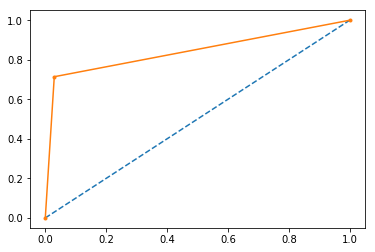

In [21]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot
from sklearn.svm import LinearSVC

svc.fit(X_train, integer_encoded_train)
# predict probabilities
probs = svc.predict(X_test)

# calculate AUC
auc = roc_auc_score(integer_encoded_test, probs)
print('AUC: %.3f' % auc)
# calculate roc curve
fpr, tpr, thresholds = roc_curve(integer_encoded_test, probs)
# plot no skill
pyplot.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
pyplot.plot(fpr, tpr, marker='.')
# show the plot
pyplot.show()